**Exercice : Un GAN conditionnel**

Dans cet exercice, il s'agit d'implémenter un Wasserstein-GAN conditionnel. Les aspects théoriques sont laissés de côté: le but est seulement de construire la boucle d'apprentissage.\
Le contexte est le suivant: on se donne un jeu d'images représentatives d'un domaine $\mathcal{D}$.\
Le GAN classique permet de générer de nouvelles images de $\mathcal{D}$. Dans cet exercice, nous allons générer des images compatibles avec une liste de valeurs de pixels données a priori.

Les cellules suivantes permettent de visualiser le jeu disponible.

In [13]:
# Imports nécessaires
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
import numpy as np

In [14]:

# Liens valable jusqu'au 17/01/2024:
# data à charger:
! wget https://www.grosfichiers.com/L7R8MLxtfzG_NwC5CzNnTSt
! tar xvf L7R8MLxtfzG_NwC5CzNnTSt
! rm L7R8MLxtfzG_NwC5CzNnTSt
# module à charger
! wget https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
! mv HAnmgiuVNGn_XtdcYCeMNnJ utile_BE.py
from utile_BE import *

--2024-01-11 17:12:29--  https://www.grosfichiers.com/L7R8MLxtfzG_NwC5CzNnTSt
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1679779840 (1.6G) [application/x-tar]
Saving to: ‘L7R8MLxtfzG_NwC5CzNnTSt’

L7R8MLxtfzG_NwC5CzN 100%[===================>]   1.56G  17.4MB/s    in 1m 52s  

2024-01-11 17:14:22 (14.3 MB/s) - ‘L7R8MLxtfzG_NwC5CzNnTSt’ saved [1679779840/1679779840]

data/
data/donut_unet_300ep_step1.pt
data/netG_180ep_WGP_scheduler75_lr005.pt
data/reid_resnet50_60ep.pt
data/tensor_test.pt
data/tensor_test_cpu.pt
data/tensor_train.pt
data/tensor_val.pt
--2024-01-11 17:14:29--  https://www.grosfichiers.com/HAnmgiuVNGn_XtdcYCeMNnJ
Resolving www.grosfichiers.com (www.grosfichiers.com)... 51.68.254.173
Connecting to www.grosfichiers.com (www.grosfichiers.com)|51.68.254.173|:443... connected.
HTTP request sent, awaiting 

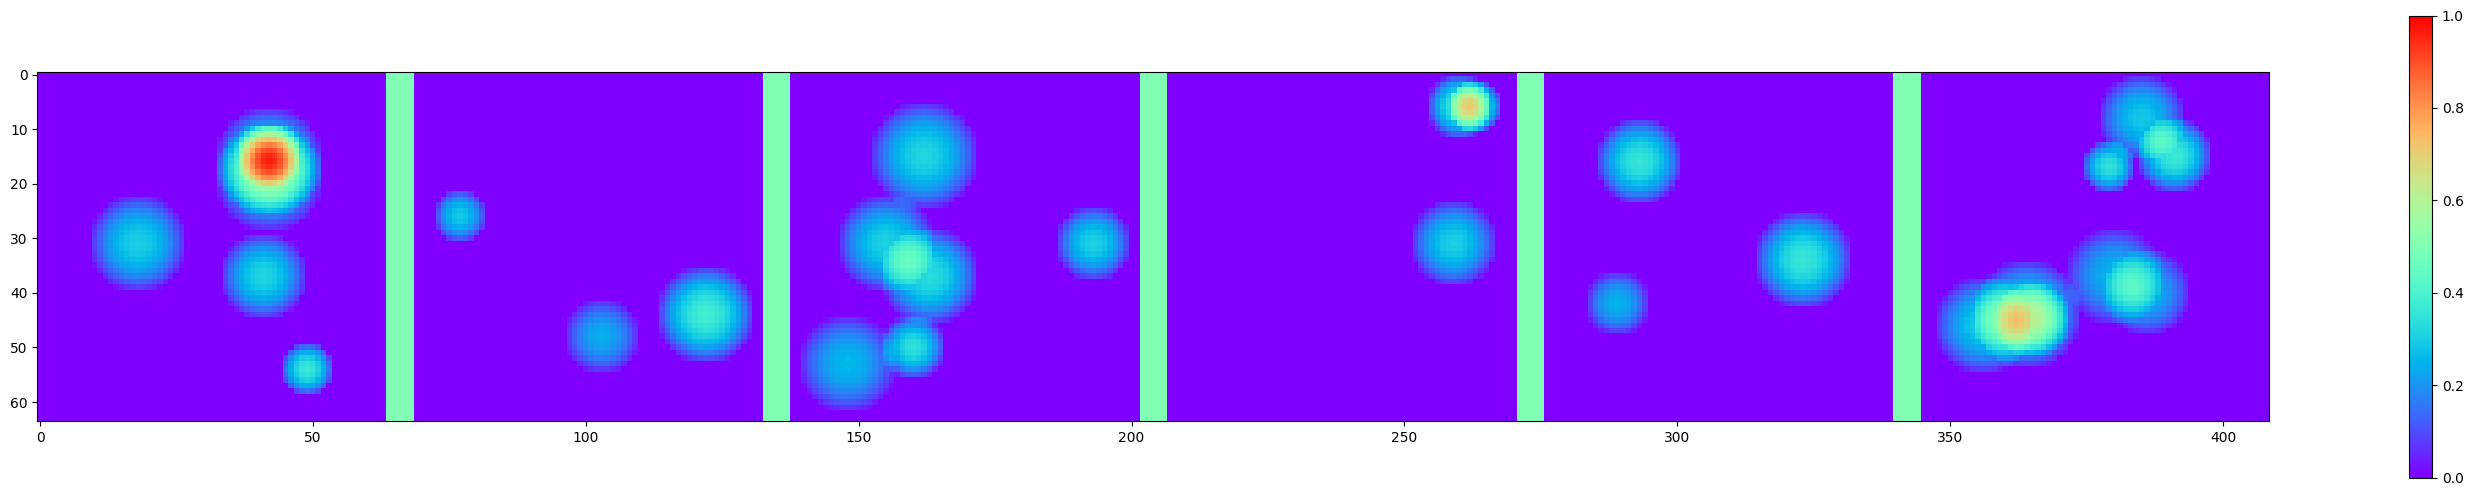

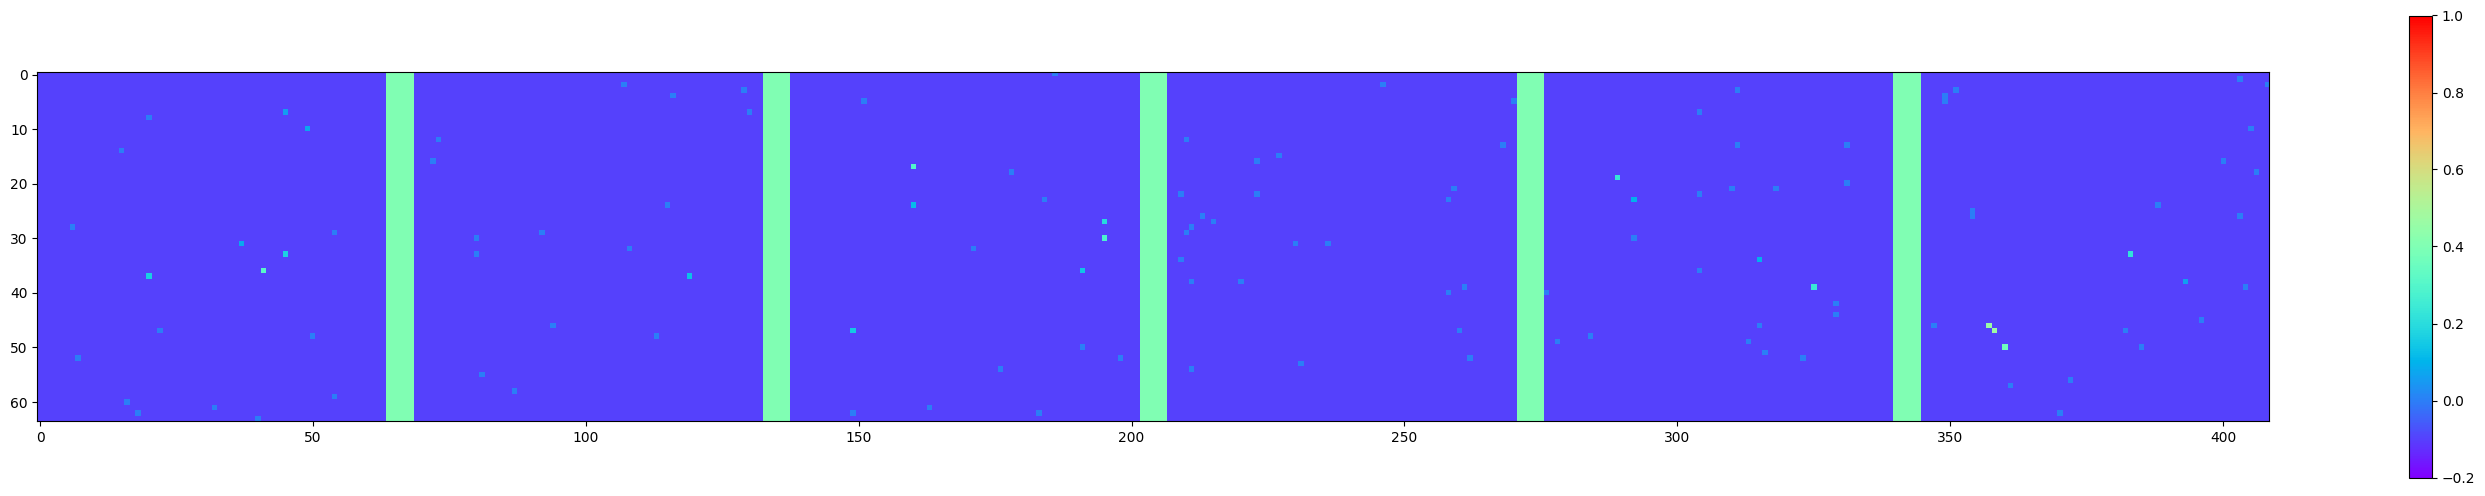

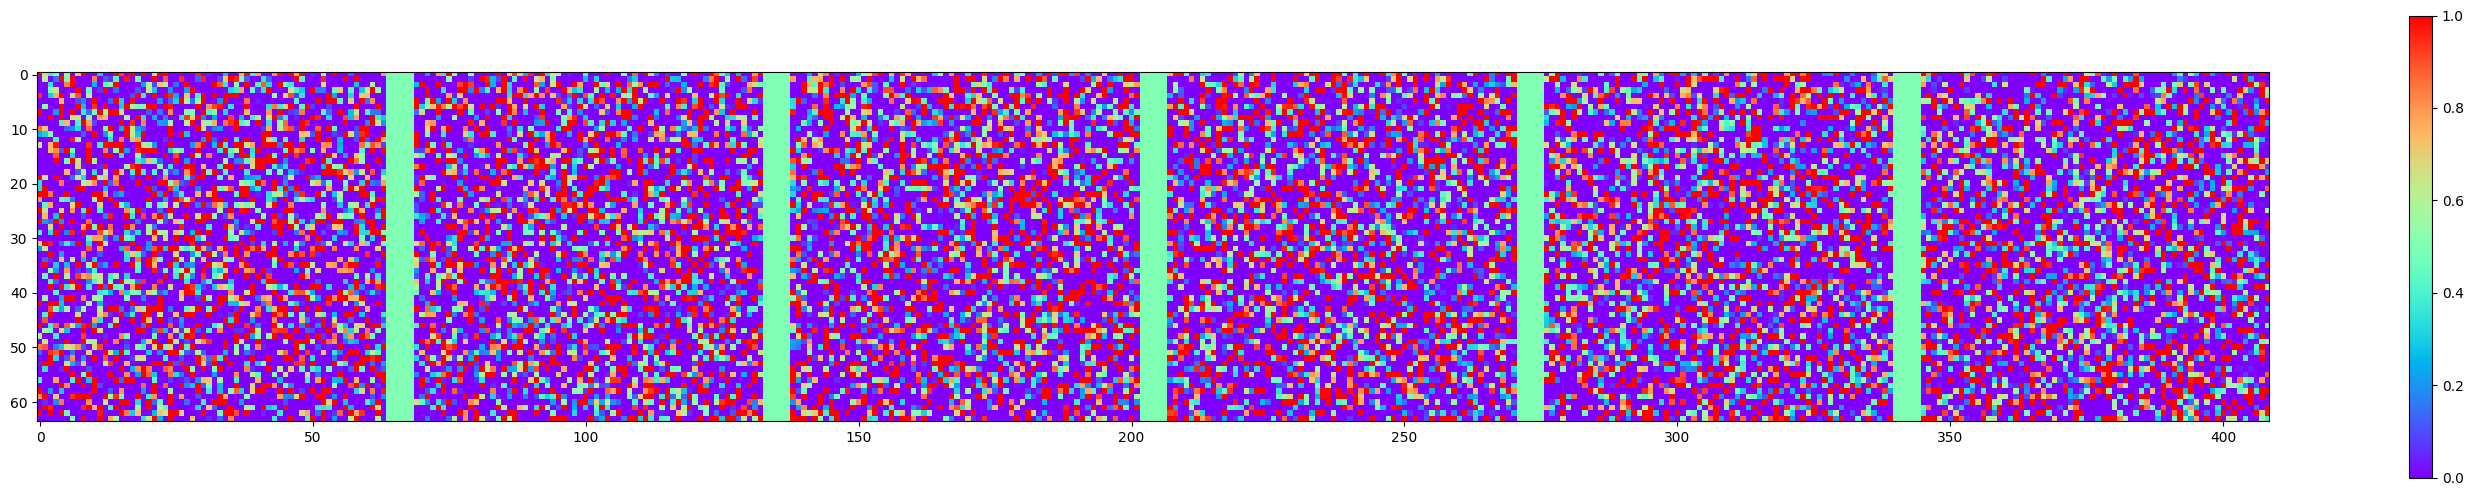

In [15]:
# proportion de pixels conservés dans yi:
dens_obs = 0.005

x , y , z = gen_condDCGAN(6,dens_obs)

# images complètes xi
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(x, 6, fig1, k=0, min_scale=0,max_scale=1)

# images fragmentaires yi: quelques pixels de xi prélevées au hasard
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(y, 6, fig2, k=0, min_scale=-0.2,max_scale=1)

# zi : échantillon d'un vecteur gaussien centré réduit
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(z, 6, fig3, k=0, min_scale=0,max_scale=1)


La première ligne contient un échantillon d'images complètes $x^i$. Ces images représente un champ scalaire à valeurs positives ou nulles.

Pour former les images framgmentaires $y^i$ (seconde ligne d'image), on a sélectionné au hasard 0.5% des pixels de chaque $x^i$, dont on a conservé les valeurs. Les valeurs de tous les autres pixels ont été fixées à -0.1.\
A considérer les $x^i$ (resp. $y^i$) comme l'échantillon d'une variable aléatoire $X$ (resp. $Y$), le but de l'exercice peut se reformuler ainsi: nous allons tenter d'échantilloner la loi $\mathcal{L}_{X|Y}$.

**Q1** Décrire brièvement le GAN classique. De combien de réseaux est-il constitué? Quels sont leur rôles respectifs ?


**1st version :**

Le GAN classique comprend un vecteur aléatoire Z, samplé d'une distribution simple, comme par exemple un vecteur gaussien centré réduit, il comprend aussi un réseau générateur d'images G, et enfin un discriminateur D, comprenant une fonction sigmoïde, et qui se charge de classifier les images selon si elles sont réelles ou non.

Le principe du GAN est donc d'entraîner simultanément le discriminateur et le générateur sur des tâches contraires : le discriminateur est entraîné à distinguer les vraies images des images générées par le générateur, et le générateur est entraîné à tromper le discriminateur.

**2nd version :**      

We have:
- A random vector $Z$, sampled from a simple distribution, for example, a centered reduced Gaussian vector.
- A generative network $G_\theta$ ($\theta$ represents the network's weights) that generates an image $G_\theta(Z)$.
- A discriminator network $D_\rho$ (similar notation as before), ending with a sigmoid function that classifies an image $x$ as "real" ($D_\rho(x) > 0.5$) or "fake" ($D_\rho(x) < 0.5$).

In the following, we omit the notations $\rho$ and $\theta$.

The algorithm consists of training $G$ and $D$ on adversarial tasks:
- $D_\rho$ is trained to distinguish images from the dataset ($x^{(i)}$) from images generated by $G_\theta$ (denoted as $G(z^{(i)})$). In the [original GAN paper](https://arxiv.org/abs/1406.2661), the authors use cross-entropy as the cost function. For a pair of two images, one fake and the other real, the cost is written as:
  $$  - {\bigg [} \ln(D(x^{(i)})) + \ln(1 - D(G(z^{(i)})) {\bigg ]}$$

- $G_\theta$ is trained to "fool" the discriminator with the adversarial cost function:
  $$  \ln(1 - D(G(z^{(i)}))) $$

A theoretical analysis of the problem is covered in the supplementary exercise sheet. Here, we implement the algorithm on synthetic images.


**Q2** Ici, pour le générateur $G$, nous utilisons un FCN. Dans le GAN classique, les entrées sont des réalisations d'un vecteur gaussien centré réduit ($z_i$).\
Pour pouvoir prendre en compte le conditionnement par les $x_i$, $G$ doit prendre en entrée les $z_i$ et les $x_i$ (on les concaténera).\
Justifier que, de son côté, le discriminateur doit prendre en entrée les $G(x_i)$ et les $z_i$.\
Compléter la cellule suivante en conséquence.

In [16]:
nc = 2
ndf = 32

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)

In [17]:
ndf = 32
n_channels = 2
n_classes = 1
size = 16

# les classes UNet et Discriminator sont codées dans utile_BE
netG = UNet(n_channels, n_classes, size).cuda()
netD = Discriminator().cuda()

**Q3** En vous inspirant de la correction du TP3, compléter la boucle d'apprentissage et la faire tourner sur dix époques:

In [18]:
# Paramétrage de la SGD
batch_size = 128
num_batches_generator = 200
num_epochs = 10

# Paramètres de l'optimizer
lr = 0.0005
beta1 = 0. # inertie de la SGD

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [19]:
real_label = 1.
fake_label = 0.

In [20]:
# Pour garder les traces des images générées à partir d'un échantillon de $z_i$ fixé:
fixed_x , fixed_y , fixed_z = gen_condDCGAN(8, p = dens_obs)

# Entrée fixe du générateur:
fixed_yz = torch.cat((fixed_y,fixed_z), dim=1).cuda()

# Listes
img_list = []
G_losses = []
D_losses = []

# Autres hyper-paramètres
n_critic = 5
clip = 0.01

In [21]:
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i in range(num_batches_generator):

        ############################
        # (1) maximisation de log(D(x)) + log(1 - D(G(z)))
        ###########################
        netG.train()
        # Ici, on procède à plusieurs (n_critic) étapes d'optimisation
        # du discriminateur.
        for j in range(n_critic):

            x , y , z = gen_condDCGAN(batch_size, p = dens_obs)

            # mise sur carte GPU
            x = x.cuda()
            y = y.cuda()
            z = z.cuda()

            netD.zero_grad()

            # concaténations :

            xy = torch.cat((x, y), dim = 1)
            yz = torch.cat((y, z), dim = 1)

            output_xy = netD(xy)

            fake = netG(yz)
            fake = fake.detach()
            fakey = torch.cat((fake,y),dim=1)
            output_fakey = netD(fakey)

            # régularisation par gradient penalty

            gradient_penalty = calculate_gradient_penalty(netD,
                                                              xy.data,
                                                              fakey.data)
            # calcul de l'erreur du discriminateur et mise à jour des gradients:
            errD = output_fakey.mean() - output_xy.mean() + 10 * gradient_penalty
            errD.backward()

            optimizerD.step()


        ############################
        # Maximisation de log(D(G(z)))
        ###########################
        netG.zero_grad()

        fake = netG(yz)
        fakey = torch.cat((fake, y), dim = 1)

        output_fakey = netD(fakey)

        errG = - output_fakey.mean()
        errG.backward()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f'
                  % (epoch+1, num_epochs, i, num_batches_generator,
                     errD.item()))

        # Enregistrement des losses
        G_losses.append(errG.item())
        D_losses.append(-errD.item())


    with torch.no_grad():
        netG.eval()
        fake = netG(fixed_yz.cuda()).detach().cpu()

    img_list.append(fake)




Starting Training Loop...
[1/10][0/200]	Loss_D: 2.0106
[1/10][50/200]	Loss_D: -1.3927
[1/10][100/200]	Loss_D: -0.6711
[1/10][150/200]	Loss_D: -0.1705
[2/10][0/200]	Loss_D: -0.1477
[2/10][50/200]	Loss_D: -0.1407
[2/10][100/200]	Loss_D: -0.1438
[2/10][150/200]	Loss_D: -0.0064
[3/10][0/200]	Loss_D: -0.1262
[3/10][50/200]	Loss_D: -0.1379
[3/10][100/200]	Loss_D: -0.1697
[3/10][150/200]	Loss_D: 0.0380
[4/10][0/200]	Loss_D: -0.1502
[4/10][50/200]	Loss_D: -0.1487
[4/10][100/200]	Loss_D: -0.0798
[4/10][150/200]	Loss_D: -0.0949
[5/10][0/200]	Loss_D: -0.2611
[5/10][50/200]	Loss_D: 0.0652
[5/10][100/200]	Loss_D: 0.0346
[5/10][150/200]	Loss_D: -0.0150
[6/10][0/200]	Loss_D: 0.1237
[6/10][50/200]	Loss_D: -0.0211
[6/10][100/200]	Loss_D: -0.0876
[6/10][150/200]	Loss_D: -0.0723
[7/10][0/200]	Loss_D: -0.0811
[7/10][50/200]	Loss_D: -0.1062
[7/10][100/200]	Loss_D: 0.0451
[7/10][150/200]	Loss_D: -0.0459
[8/10][0/200]	Loss_D: 0.1005
[8/10][50/200]	Loss_D: -0.1390
[8/10][100/200]	Loss_D: -0.0726
[8/10][150/20

**Q5** Visualiser quelques images et commentez.

10


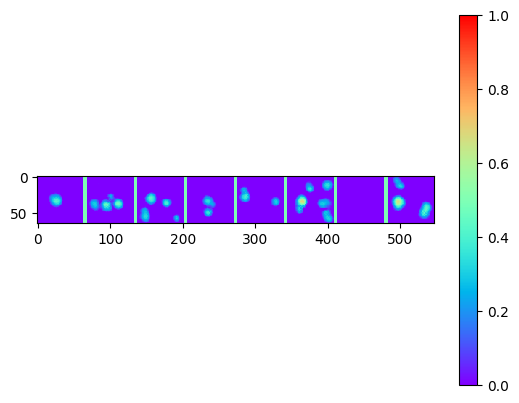

In [22]:
print(len(img_list))
voir_batch2D(img_list[-1], 8, fig1, k=0, min_scale=0,max_scale=1)


Au bout de quelques epochs :     
- les disques sont encore mal individualisés
- la condition ne sembl pas prise en compte (ici, les points rouges sont des mesures strictement positives. Le réseau aurait dû générer des disques à leur endroit)
- des figures en damier apparaissent : elles sont typiques d'unUNet qui n'a pas été correctement entraîné

**Q6** Pour obtenir un GAN qui tienne compte de la condition contenue dans les $y_i$, il est nécessaire de pousser l'apprentissage plus loin. Le fichier *data/netG_180ep_WGP_scheduler75_lr005.pt* contient les poids obtenus après apprentissage sur 300 époques.
Charger ces poids et visualiser plusieurs images pour les mêmes entrée $x_i$ et $z_i$. Vérifier la cohérence et conclure.

In [23]:
weights = torch.load('data/netG_180ep_WGP_scheduler75_lr005.pt')
netG.load_state_dict(weights['model_state_dict'])

<All keys matched successfully>

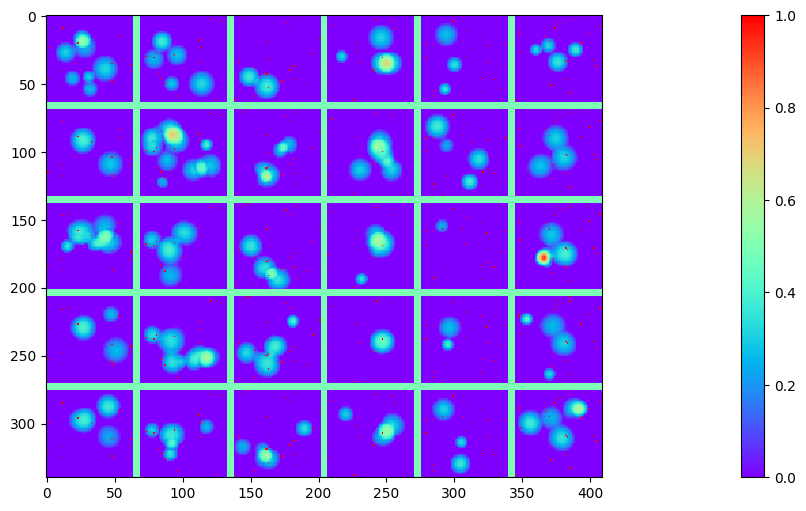

In [24]:
netG.eval()

x , y , z = gen_condDCGAN(6, p = dens_obs)

n = 4

real_and_fakes = [x + 1*(y>=0).float()]
real = x + 1*(y>=0).float()
fakes = []

for i in range(n):
    _ , _ , z = gen_condDCGAN(6, p = dens_obs)

    yz = torch.cat((y,z),dim=1).cuda()
    with torch.no_grad():
      fake = netG(yz).cpu() + 1 * (y>=0).float()
    fakes.append(fake)

fakes = torch.cat(fakes, dim=0)
real_and_fakes = torch.cat((real,fakes), dim=0)

fig1 = plt.figure(4, figsize=(36, 6))
voir_batch2D(real_and_fakes, 6, fig1, k=0, min_scale=0, max_scale=1)


In [27]:
x , y, z = gen_condDCGAN(128, p = dens_obs)

n = 128
real_on_sensors_strictpos = []
diff_fake_on_sensors_strictpos = []
diff_fake_on_sensors_nulls = []
real_on_sensors = []
diff_fake_on_sensors = []

for i in range(n):
    _, _, z = gen_condDCGAN(128, p = dens_obs)
    yz = torch.cat((y,z),dim=1).cuda()
    with torch.no_grad():
      fake = netG(yz).cpu()
      real_on_sensors_strictpos.append(y[y>0])
      diff_fake_on_sensors_strictpos.append(np.abs(fake[y>0]-y[y>0]))
      diff_fake_on_sensors_nulls.append(np.abs(fake[y == 0] - y[y == 0]))
      real_on_sensors.append(y[y >= 0])
      diff_fake_on_sensors.append(np.abs(fake[y >= 0] - y[y >= 0]))



In [28]:
print('moyenne des mesures str. positives')
print(torch.cat(real_on_sensors_strictpos, dim=0).mean())
print('écart real-fake aux points de mesures str. positives')
print(torch.cat(diff_fake_on_sensors_strictpos, dim=0).mean())
print('écart real-fake aux points de mesures nulles')
print(torch.cat(diff_fake_on_sensors_nulls, dim=0).mean())

print('moyenne des mesures disponibles dans y')
print(torch.cat(real_on_sensors, dim=0).mean())
print('écart real-fake aux points de mesures')
print(torch.cat(diff_fake_on_sensors, dim=0).mean())

moyenne des mesures str. positives
tensor(0.1997)
écart real-fake aux points de mesures str. positives
tensor(0.0520)
écart real-fake aux points de mesures nulles
tensor(0.0050)
moyenne des mesures disponibles dans y
tensor(0.0328)
écart real-fake aux points de mesures
tensor(0.0127)


Au plan qualitatif, les disques générés ressemblent aux disques originaux. En particulier, les zones de coalescence entre les disques sont assez bien rendues.

De plus, ces disques semblent cohérents avec la valeur des mesures ponctuelles et semblent correctement échantillonner la loi conditionnelle:
- il n'y a (très généralement) pas de disque lorsque la valeur est nulle.
- il y a (très généralement) un disque là où la valeur mesurée est non-nulle.

Enfin la densité conditionnelle semble correctement échantillonnée (diversité des formes et des rayons).

Au plan quantitatif, on peut très rapidement comparer la valeur des images générées aux points de mesures avec les mesures elles-mêmes (deuxième cellule et troisième cellule au-dessus). L'écart représente 1/3 de la moyenne.

La cellule au-dessus permet même de préciser: lorsque la mesure est nulle, la valeur générée correspondante est faible (en moyenne 0.005), mais l'écart est nettement plus grand lorsque la mesure est non nulle (environ 0.05, soit 20% de la valeur moyenne)

Le résultat est donc encore imparfait.